In [298]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.14.5
pandas 0.20.3
scipy 0.19.1
sklearn 0.19.0
lightgbm 2.1.2


In [299]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Load Data

In [477]:
train = pd.read_csv('./dataset/sales_train.csv')
test  = pd.read_csv('./dataset/test.csv')
shops = pd.read_csv('./dataset/shops.csv')
item_cats = pd.read_csv('./dataset/item_categories.csv')
items = pd.read_csv('./dataset/items.csv')
sample_submission = pd.read_csv('./dataset/sample_submission.csv')

In [478]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00
5,10.01.2013,0,25,2564,349.00,1.00
6,02.01.2013,0,25,2565,549.00,1.00
7,04.01.2013,0,25,2572,239.00,1.00
8,11.01.2013,0,25,2572,299.00,1.00
9,03.01.2013,0,25,2573,299.00,3.00


## EDA

In [479]:
pd.options.display.float_format = '{:20,.2f}'.format
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,"2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00"
mean,14.57,33.00,"10,197.23",890.85,1.24
std,9.42,16.23,"6,324.30","1,729.80",2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,"4,476.00",249.00,1.00
50%,14.00,31.00,"9,343.00",399.00,1.00
75%,23.00,47.00,"15,684.00",999.00,1.00
max,33.00,59.00,"22,169.00","307,980.00","2,169.00"


In [480]:
train['date_formatted'] = pd.to_datetime(train.date, format='%d.%m.%Y')
train[['day', 'month', 'year']] = train.date.str.split('.',expand=True)
train['sales'] = train.item_price * train.item_cnt_day
train.head(5)
train.loc[train.date_block_num == 33].head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,sales
2882335,23.10.2015,33,45,13315,649.00,1.00,2015-10-23,23,10,2015,649.00
2882336,05.10.2015,33,45,13880,229.00,1.00,2015-10-05,05,10,2015,229.00
2882337,02.10.2015,33,45,13881,659.00,1.00,2015-10-02,02,10,2015,659.00
2882338,12.10.2015,33,45,13881,659.00,1.00,2015-10-12,12,10,2015,659.00
2882339,04.10.2015,33,45,13923,169.00,1.00,2015-10-04,04,10,2015,169.00
2882340,31.10.2015,33,45,14227,99.00,1.00,2015-10-31,31,10,2015,99.00
2882341,12.10.2015,33,45,14931,799.00,1.00,2015-10-12,12,10,2015,799.00
2882342,05.10.2015,33,45,14101,449.00,1.00,2015-10-05,05,10,2015,449.00
2882343,20.10.2015,33,45,14957,299.00,1.00,2015-10-20,20,10,2015,299.00
2882344,05.10.2015,33,45,14102,749.00,1.00,2015-10-05,05,10,2015,749.00


/home/izlley/python-venv/python3-env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


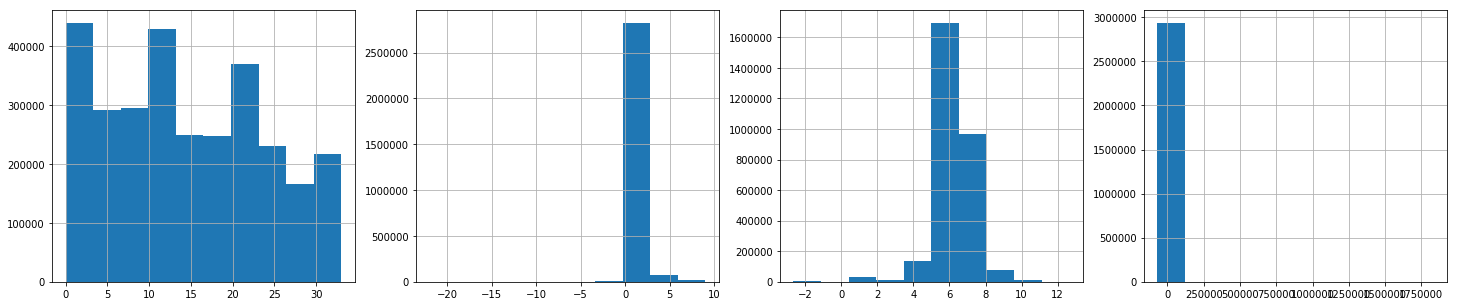

In [398]:
fig, axes = plt.subplots(1, 4, figsize=(25,5))
train.date_block_num.hist(ax=axes[0])
train[train['item_cnt_day'] < 10].item_cnt_day.hist(ax=axes[1])
np.log(train['item_price']).hist(ax=axes[2])
train.sales.hist(ax=axes[3])

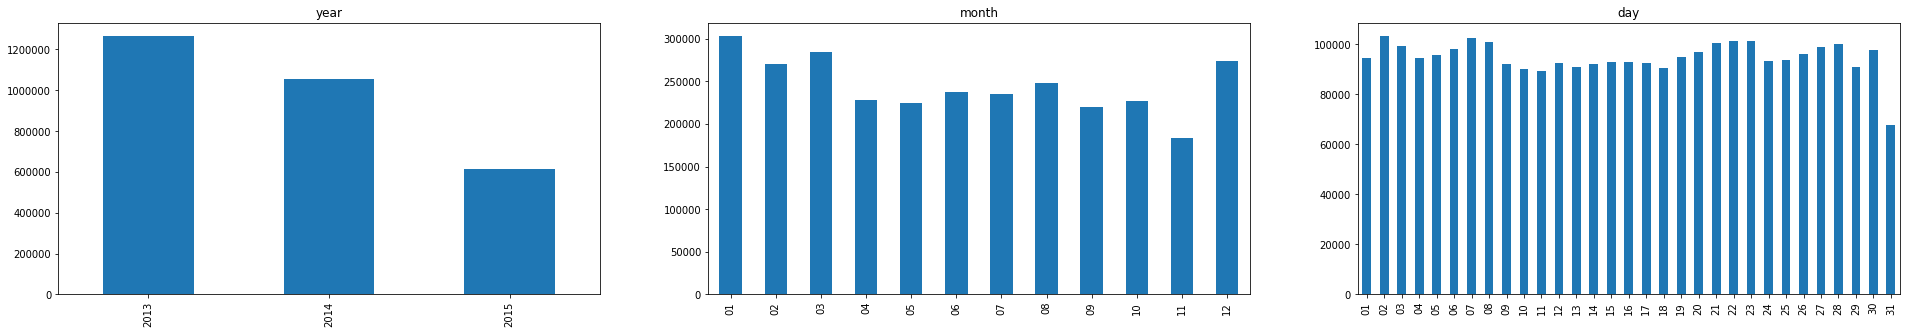

In [399]:
fig, axes = plt.subplots(1, 3, figsize=(33, 5))

train.year.value_counts().sort_index().plot.bar(ax=axes[0], title='year')
train.month.value_counts().sort_index().plot.bar(ax=axes[1], title='month')
train.day.value_counts().sort_index().plot.bar(ax=axes[2], title='day')

Looks like number of sales data points has dropped each year. Also looks like December through March show the highest number of sales points. This could be related to the holiday times.

## Trends
As with most ecommerce datasets, we see sales spike around Christmas and New Years every year.

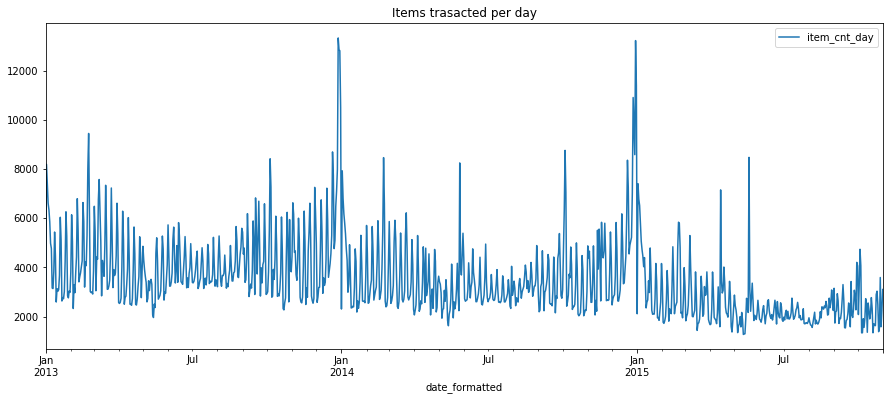

In [400]:
train.groupby('date_formatted').agg({'item_cnt_day':'sum'}) \
  .plot(figsize=(15,6), title='Items trasacted per day')

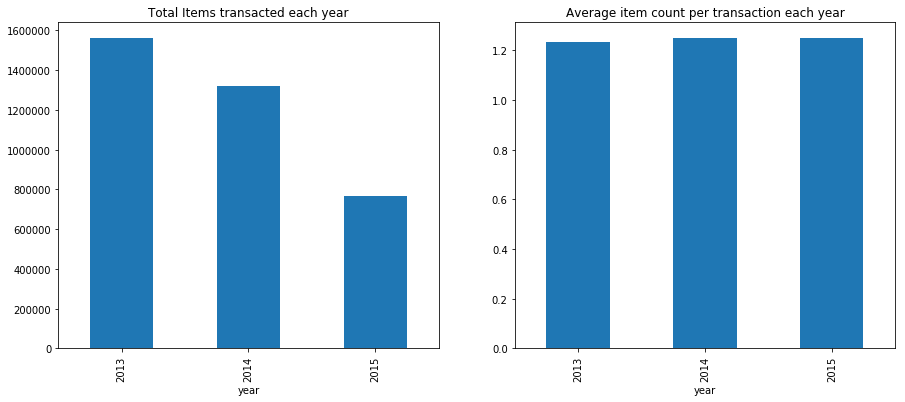

In [401]:
fig, axes = plt.subplots(1, 2, figsize=(33, 5))

train.groupby('year').item_cnt_day.sum().plot.bar(figsize=(15,6), title='Total Items transacted each year', ax=axes[0])
train.groupby('year').item_cnt_day.mean().plot.bar(figsize=(15,6), title='Average item count per transaction each year', ax=axes[1])

Since the average daily item count per transaction is the same each year, it looks like decline is due to the total number of transactions.

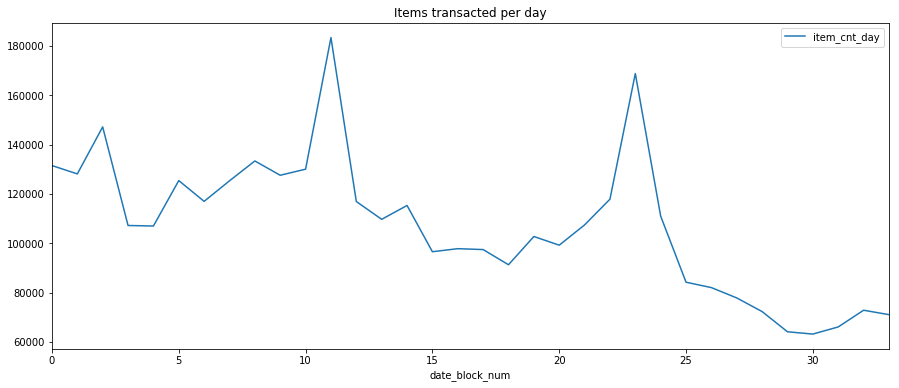

In [402]:
train.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(15,6), title='Items transacted per day')

### Weekly Seasonality
we can clearly see a rise in sales on Friday-Sunday

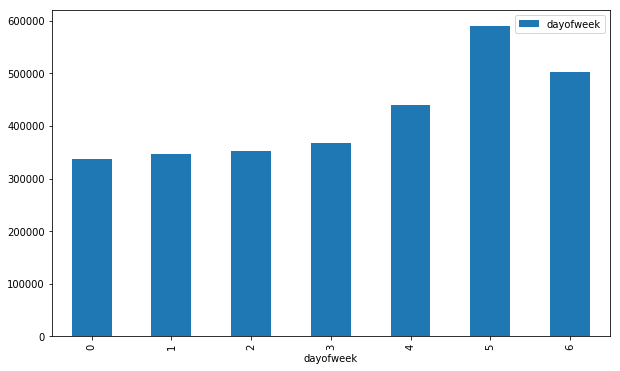

In [403]:
train['dayofweek'] = train.date_formatted.dt.dayofweek
train.groupby('dayofweek').agg({'dayofweek': 'count'}).plot.bar(figsize=(10, 6))

### Monthly seasonality

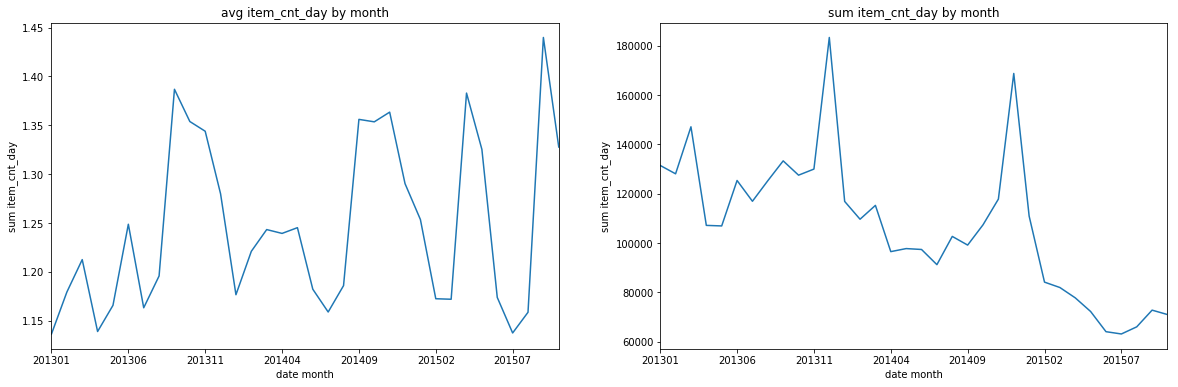

In [405]:
train['date_month'] = (train.year + train.month)
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
ax = train.groupby('date_month').item_cnt_day.mean()\
  .plot(x_compat=True, title='avg item_cnt_day by month', figsize=(20, 6), ax=axes[0])
ax.set(xlabel='date month', ylabel='sum item_cnt_day')
    
ax = train.groupby('date_month').item_cnt_day.sum()\
  .plot(x_compat=True, title='sum item_cnt_day by month', figsize=(20, 6), ax=axes[1])
    
ax.set(xlabel='date month', ylabel='sum item_cnt_day')

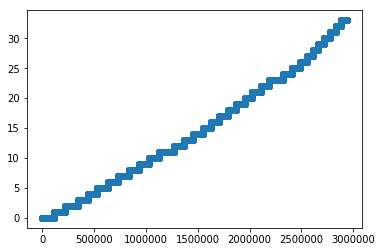

In [406]:
plt.scatter(train.index, train.date_block_num)

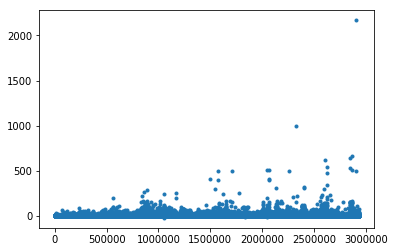

In [407]:
plt.plot(train.item_cnt_day, '.')

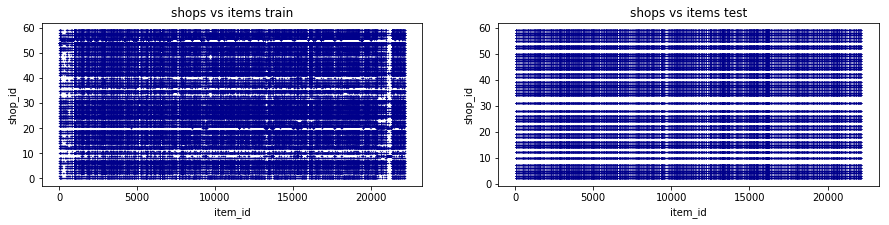

In [408]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
train.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1,\
                                                                 ax=axes[0], title='shops vs items train')
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1,\
                                                                 ax=axes[1], title='shops vs items test')

### Leakage

In [484]:
test_train_merged = test.merge(train, how='left', on=['shop_id', 'item_id'])

In [501]:
test_train_merged['date_block_num'].isnull().sum()

102796

In [502]:
test_train_merged['date_block_num'].notnull().sum()

1224439

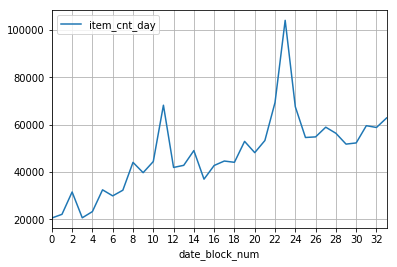

In [523]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

df_plot = test_train_merged.loc[test_train_merged.date_block_num.notnull()]\
.groupby('date_block_num').agg({'item_cnt_day': 'sum'})

# .plot(figsize=(10,5), grid=True, x_compat=True, title='Items transacted per day')
ax = df_plot.plot(x_compat=True, grid=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
plt.show()

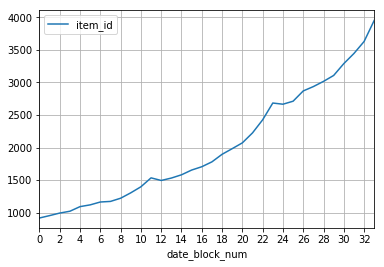

In [524]:
df_plot = test_train_merged.loc[test_train_merged.date_block_num.notnull()].\
groupby('date_block_num').agg({'item_id': 'nunique'}) #.plot(figsize=(10,5), title='Items transacted per day')

ax = df_plot.plot(x_compat=True, grid=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
plt.show()

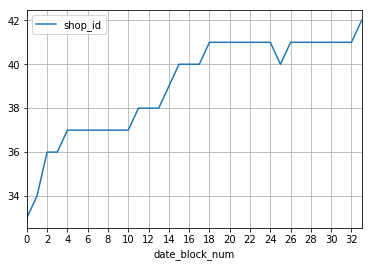

In [525]:
df_plot = test_train_merged.loc[test_train_merged.date_block_num.notnull()].\
groupby('date_block_num').agg({'shop_id': 'nunique'}) #.plot(figsize=(10,5), title='Items transacted per day')

ax = df_plot.plot(x_compat=True, grid=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
plt.show()

## Map Items Categorries
Map categories to more narrow ones

In [413]:
# load data again

train = pd.read_csv('./dataset/sales_train.csv')
test  = pd.read_csv('./dataset/test.csv')

In [466]:
l_cat = list(item_cats.item_category_name)

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'
    
item_cats['cats'] = l_cat
#item_cats

In [467]:
from sklearn import preprocessing

label_en = preprocessing.LabelEncoder()
item_cats['cat2_l'] = label_en.fit_transform(item_cats.cats)

items = items.merge(item_cats, how='left', on=['item_category_id'])
items.head(10)

,item_name,item_id,item_category_id,item_category_name,cats,cat2_l
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Movie,7
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),Soft,10
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Movie,7
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Movie,7
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Movie,7
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Movie,7
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40,Кино - DVD,Movie,7
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40,Кино - DVD,Movie,7
8,***ЧАЙ С МУССОЛИНИ D,8,40,Кино - DVD,Movie,7
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40,Кино - DVD,Movie,7


In [468]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id','cat2_l']].drop_duplicates()

train = pd.merge(train, item_category_mapping, how='left', on='item_id')
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,cat2_l
0,02.01.2013,0,59,22154,999.00,1.00,37,7
1,03.01.2013,0,25,2552,899.00,1.00,58,8
2,05.01.2013,0,25,2552,899.00,-1.00,58,8
3,06.01.2013,0,25,2554,"1,709.05",1.00,58,8
4,15.01.2013,0,25,2555,"1,099.00",1.00,56,8
5,10.01.2013,0,25,2564,349.00,1.00,59,8
6,02.01.2013,0,25,2565,549.00,1.00,56,8
7,04.01.2013,0,25,2572,239.00,1.00,55,8
8,11.01.2013,0,25,2572,299.00,1.00,55,8
9,03.01.2013,0,25,2573,299.00,3.00,55,8


## Get a feature matrix

In [469]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid = pd.merge(grid, item_category_mapping, how='left', on='item_id')

# Groupby data to get shop-item-month aggregates
gb = train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = train.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = train.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with cat_id-month aggregates (sum)
gb = train.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_cat_id':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

# Same as above but with cat_id-month aggregates (avg)
gb = train.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'avg_target_cat_id':'mean'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

all_data.head(15)

/home/izlley/python-venv/python3-env/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,item_category_id,cat2_l,target,target_shop,target_item,target_cat_id,avg_target_cat_id
0,59,22154,0,37,7,1.00,"2,017.00",18.00,"6,094.00",1.05
1,59,2552,0,58,8,0.00,"2,017.00",0.00,287.00,0.97
2,59,2554,0,58,8,0.00,"2,017.00",1.00,287.00,0.97
3,59,2555,0,56,8,0.00,"2,017.00",2.00,268.00,1.01
4,59,2564,0,59,8,0.00,"2,017.00",5.00,701.00,0.99
5,59,2565,0,56,8,0.00,"2,017.00",2.00,268.00,1.01
6,59,2572,0,55,8,0.00,"2,017.00",12.00,"12,527.00",1.03
7,59,2573,0,55,8,0.00,"2,017.00",16.00,"12,527.00",1.03
8,59,2574,0,55,8,2.00,"2,017.00",119.00,"12,527.00",1.03
9,59,2593,0,55,8,0.00,"2,017.00",5.00,"12,527.00",1.03


### Mean encoding

In [421]:
all_data['item_target_enc'] = np.nan

cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcount = all_data.groupby('item_id').cumcount()
all_data['item_target_enc'] = cumsum/cumcount

all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

all_data.head(15)

0.5037485458169257


,shop_id,item_id,date_block_num,item_category_id,cat2_l,target,target_shop,target_item,target_cat_id,avg_target_cat_id,item_target_enc
0,59,22154,0,37,7,1.00,"2,017.00",18.00,"6,094.00",1.05,0.33
1,59,2552,0,58,8,0.00,"2,017.00",0.00,287.00,0.97,0.33
2,59,2554,0,58,8,0.00,"2,017.00",1.00,287.00,0.97,0.33
3,59,2555,0,56,8,0.00,"2,017.00",2.00,268.00,1.01,0.33
4,59,2564,0,59,8,0.00,"2,017.00",5.00,701.00,0.99,0.33
5,59,2565,0,56,8,0.00,"2,017.00",2.00,268.00,1.01,0.33
6,59,2572,0,55,8,0.00,"2,017.00",12.00,"12,527.00",1.03,0.33
7,59,2573,0,55,8,0.00,"2,017.00",16.00,"12,527.00",1.03,0.33
8,59,2574,0,55,8,2.00,"2,017.00",119.00,"12,527.00",1.03,0.33
9,59,2593,0,55,8,0.00,"2,017.00",5.00,"12,527.00",1.03,0.33


In [470]:
from sklearn.model_selection import KFold

all_data['item_target_enc'] = np.nan

kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(all_data):
    item_id_target_mean = all_data.iloc[train_index].groupby('item_id').target.mean()
    all_data['item_target_enc'].iloc[test_index] = all_data['item_id'].iloc[test_index].map(item_id_target_mean)

# Fill NaNs
default_val = 0.3343
all_data['item_target_enc'].fillna(default_val, inplace=True) 

# You will need to compute correlation like that
encoded_feature = all_data['item_target_enc'].values
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

/home/izlley/python-venv/python3-env/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0.4166330172564691


In [471]:
# to make test dataset
test['date_block_num'] = 34

test = pd.merge(test, item_category_mapping, how='left', on='item_id')
test.head(10)

test['target'] = np.nan
test['target_shop'] = np.nan
test['target_item'] = np.nan
test['target_cat_id'] = np.nan
test['avg_target_cat_id'] = np.nan
test['item_target_enc'] = np.nan

all_data = pd.concat([all_data, test.drop(['ID'], axis=1)])
all_data.loc[all_data.date_block_num == 34].head(5)

,shop_id,item_id,date_block_num,item_category_id,cat2_l,target,target_shop,target_item,target_cat_id,avg_target_cat_id,item_target_enc
0,5,5037,34,19,5,nan,nan,nan,nan,nan,nan
1,5,5320,34,55,8,nan,nan,nan,nan,nan,nan
2,5,5233,34,19,5,nan,nan,nan,nan,nan,nan
3,5,5232,34,23,5,nan,nan,nan,nan,nan,nan
4,5,5268,34,20,5,nan,nan,nan,nan,nan,nan


In [472]:
# List of columns that we will use to create lags
index_cols = ['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'cat2_l']
cols_to_rename = list(all_data.columns.difference(index_cols)) 
print(cols_to_rename)

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

#print(train_shift)
del train_shift

#print(all_data.T)

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
#print(all_data.columns)
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
#print(fit_cols)

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

all_data = downcast_dtypes(all_data)
gc.collect();

all_data.head(15)

['avg_target_cat_id', 'item_target_enc', 'target', 'target_cat_id', 'target_item', 'target_shop']


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

,shop_id,item_id,date_block_num,item_category_id,cat2_l,target,target_shop,target_item,target_cat_id,avg_target_cat_id,item_target_enc,avg_target_cat_id_lag_1,item_target_enc_lag_1,target_lag_1,target_cat_id_lag_1,target_item_lag_1,target_shop_lag_1,avg_target_cat_id_lag_2,item_target_enc_lag_2,target_lag_2,target_cat_id_lag_2,target_item_lag_2,target_shop_lag_2,avg_target_cat_id_lag_3,item_target_enc_lag_3,target_lag_3,target_cat_id_lag_3,target_item_lag_3,target_shop_lag_3,avg_target_cat_id_lag_4,item_target_enc_lag_4,target_lag_4,target_cat_id_lag_4,target_item_lag_4,target_shop_lag_4,avg_target_cat_id_lag_5,item_target_enc_lag_5,target_lag_5,target_cat_id_lag_5,target_item_lag_5,target_shop_lag_5,avg_target_cat_id_lag_12,item_target_enc_lag_12,target_lag_12,target_cat_id_lag_12,target_item_lag_12,target_shop_lag_12
4488756,54,10297,12,37,7,4.00,"8,198.00",23.00,"7,511.00",1.02,0.10,1.05,0.13,3.00,"9,959.00",42.00,"10,055.00",1.07,0.13,0.00,"7,420.00",2.00,"7,978.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4488757,54,10296,12,38,7,3.00,"8,198.00",17.00,"1,410.00",1.00,0.11,1.02,0.13,0.00,"2,052.00",24.00,"10,055.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4488758,54,10298,12,40,7,14.00,"8,198.00",182.00,"22,065.00",1.11,3.12,1.16,1.78,21.00,"28,598.00",369.00,"10,055.00",1.19,1.78,119.00,"25,433.00","1,309.00","7,978.00",1.17,1.78,7.00,"24,173.00",144.00,"6,676.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4488759,54,10300,12,37,7,3.00,"8,198.00",26.00,"7,511.00",1.02,0.70,1.05,0.26,1.00,"9,959.00",54.00,"10,055.00",1.07,0.26,31.00,"7,420.00",361.00,"7,978.00",1.06,0.26,0.00,"6,950.00",53.00,"6,676.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4488760,54,10284,12,57,8,1.00,"8,198.00",3.00,984.00,1.00,0.09,1.02,0.08,0.00,"1,425.00",4.00,"10,055.00",1.01,0.08,0.00,"1,054.00",3.00,"7,978.00",1.01,0.08,0.00,"1,080.00",5.00,"6,676.00",1.02,0.08,0.00,"1,124.00",3.00,"7,827.00",1.01,0.08,0.00,"1,316.00",10.00,"7,792.00",0.00,0.00,0.00,0.00,0.00,0.00
4488761,54,10292,12,40,7,9.00,"8,198.00",93.00,"22,065.00",1.11,1.76,1.16,0.86,8.00,"28,598.00",156.00,"10,055.00",1.19,0.86,16.00,"25,433.00",203.00,"7,978.00",1.17,0.86,15.00,"24,173.00",279.00,"6,676.00",1.16,0.86,38.00,"23,348.00",445.00,"7,827.00",1.10,0.86,11.00,"24,130.00",140.00,"7,792.00",0.00,0.00,0.00,0.00,0.00,0.00
4488762,54,10109,12,40,7,2.00,"8,198.00",17.00,"22,065.00",1.11,0.32,1.16,0.25,1.00,"28,598.00",19.00,"10,055.00",1.19,0.25,0.00,"25,433.00",15.00,"7,978.00",1.17,0.25,0.00,"24,173.00",17.00,"6,676.00",1.16,0.25,0.00,"23,348.00",18.00,"7,827.00",1.10,0.25,1.00,"24,130.00",28.00,"7,792.00",0.00,0.00,0.00,0.00,0.00,0.00
4488763,54,10107,12,37,7,1.00,"8,198.00",26.00,"7,511.00",1.02,0.49,1.05,0.24,2.00,"9,959.00",23.00,"10,055.00",1.07,0.24,6.00,"7,420.00",39.00,"7,978.00",1.06,0.24,2.00,"6,950.00",48.00,"6,676.00",1.08,0.24,6.00,"7,659.00",67.00,"7,827.00",1.05,0.24,2.00,"8,680.00",75.00,"7,792.00",1.05,0.49,3.00,"6,094.00",32.00,"9,386.00"
4488764,54,10121,12,37,7,1.00,"8,198.00",1.00,"7,511.00",1.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.06,0.03,0.00,"6,950.00",2.00,"6,676.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.05,0.03,1.00,"6,094.00",2.00,"9,386.00"
4488765,54,10143,12,55,8,1.00,"8,198.00",12.00,"10,216.00",1.02,0.11,1.05,0.13,1.00,"16,186.00",18.00,"10,055.00",1.03,0.13,0.00,"11,541.00",2.00,"7,978.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Split dataset to make Train/Val/Test set

In [425]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [426]:
dates_train = dates[dates <  last_block - 1]
dates_train_val = dates[dates <  last_block]

X_train = all_data.loc[dates <  last_block - 1].drop(to_drop_cols, axis=1)
y_train = all_data.loc[dates <  last_block - 1, 'target'].values

X_val =  all_data.loc[dates == last_block - 1].drop(to_drop_cols, axis=1)
y_val =  all_data.loc[dates == last_block - 1, 'target'].values

X_train_val = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
y_train_val = all_data.loc[dates <  last_block, 'target'].values

X_test = all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

In [427]:
print(to_drop_cols)
print(X_train.shape)
print(y_train.shape)
print(dates_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print(X_test.shape)

['item_target_enc', 'avg_target_cat_id', 'target', 'target_cat_id', 'target_item', 'target_shop', 'date_block_num']
(6186922, 40)
(6186922,)
(6186922,)
(238172, 40)
(238172,)
(6425094, 40)
(6425094,)
(214200, 40)


In [428]:
dates_train.describe()

count           6,186,922.00
mean                   21.16
std                     5.87
min                    12.00
25%                    16.00
50%                    21.00
75%                    26.00
max                    32.00
Name: date_block_num, dtype: float64

## First level models
### Linear regression

In [475]:
# [LR, GBDT, Neural Network, kNN]
# train dates : 12 ~ 32, validation date : 33
lr_1st = LinearRegression()
lr_1st.fit(X_train.values, y_train)
pred_lr_t = lr_1st.predict(X_train.values)
pred_lr_v = lr_1st.predict(X_val.values)

print('Train R-squared loss for linreg is %f' % r2_score(y_train, pred_lr_t))
print('Test R-squared loss for linreg is %f' % r2_score(y_val, pred_lr))

Train R-squared loss for linreg is 0.471466
Test R-squared loss for linreg is 0.255206


### LightGBM

In [529]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':10, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_val, y_val, reference=lgb_train)

evals_result = {}
lgb_1st = lgb.train(lgb_params,
                lgb.Dataset(X_train, label=y_train),
                num_boost_round=100,
                valid_sets={lgb_train, lgb_test},
                evals_result=evals_result,
                verbose_eval=10)

#lgb_1st = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb_t = lgb_1st.predict(X_train)
pred_lgb_v = lgb_1st.predict(X_val)

print('Train R-squared loss for LightGBM is %f' % r2_score(y_train, pred_lgb_t))
print('Test R-squared loss for LightGBM is %f' % r2_score(y_val, pred_lgb_v))

[10]	valid_0's rmse: 5.0684	valid_1's rmse: 3.17571
[20]	valid_0's rmse: 4.89915	valid_1's rmse: 2.944
[30]	valid_0's rmse: 4.78357	valid_1's rmse: 2.78349
[40]	valid_0's rmse: 4.70679	valid_1's rmse: 2.67776
[50]	valid_0's rmse: 4.66096	valid_1's rmse: 2.60556
[60]	valid_0's rmse: 4.62942	valid_1's rmse: 2.55475
[70]	valid_0's rmse: 4.60469	valid_1's rmse: 2.51866
[80]	valid_0's rmse: 4.59473	valid_1's rmse: 2.49125
[90]	valid_0's rmse: 4.57896	valid_1's rmse: 2.46995
[100]	valid_0's rmse: 4.57503	valid_1's rmse: 2.45359
Train R-squared loss for LightGBM is 0.517337
Test R-squared loss for LightGBM is 0.266737


Plot metrics recorded during training...


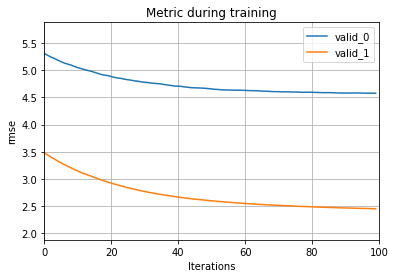

Plot feature importances...


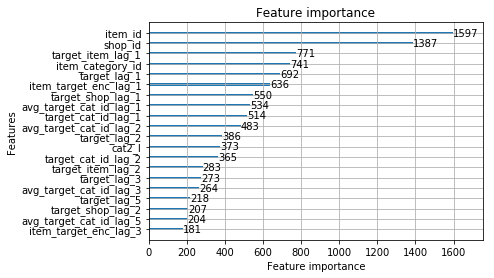

In [530]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(lgb_1st, max_num_features=20)
plt.show()

#print('Plot 84th tree...')
#ax = lgb.plot_tree(lgb_1st, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
#plt.show()

#print('Plot 84th tree with graphviz...')
#graph = lgb.create_tree_digraph(lgb_1st, tree_index=83, name='Tree84')
#graph.render(view=True)

### Neural Net

In [435]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils


def baseline_nn_model():
  nn_model = Sequential()
  nn_model.add(Dense(10, input_dim=40, kernel_initializer='normal', activation='relu'))
  nn_model.add(Dense(10, kernel_initializer='normal', activation='relu'))
  nn_model.add(Dense(1, kernel_initializer='normal'))

  nn_model.compile(loss='mean_squared_error', optimizer='adam')
  return nn_model

In [436]:
nn_1st = baseline_nn_model()
nn_1st.fit(X_train, y_train, epochs=10, batch_size=256, verbose=True, shuffle=False)
pred_nn_train = nn_1st.predict(X_train)
pred_nn_val = nn_1st.predict(X_val)

print('Train R-squared loss for NN is %f' % r2_score(y_train, pred_nn_train))
print('Test R-squared loss for NN is %f' % r2_score(y_val, pred_nn_val))

Epoch 1/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 9.1411
Epoch 2/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 7.5219
Epoch 3/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 7.3575
Epoch 4/10
6186922/6186922 [==============================] - 41s 7us/step - loss: 7.3299
Epoch 5/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 7.2801
Epoch 6/10
6186922/6186922 [==============================] - 41s 7us/step - loss: 7.1504
Epoch 7/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 7.1557
Epoch 8/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 7.0735
Epoch 9/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 7.0196
Epoch 10/10
6186922/6186922 [==============================] - 42s 7us/step - loss: 6.9582
Train R-squared loss for NN is 0.293322
Test R-squared loss for NN is 0.167720


## Train meta-features

In [437]:
dates_train_val_level2 = dates_train_val[dates_train_val.isin([28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_val_level2 = y_train_val[dates_train_val.isin([28, 29, 30, 31, 32, 33])]

print(dates_train_val.shape)
print(dates_train_val_level2.shape)
print(y_train_val_level2.shape)

(6425094,)
(1356992,)
(1356992,)


In [ ]:
X_train_val_level2 = np.zeros([y_train_val_level2.shape[0], 3])

for cur_block_num in [28, 29, 30, 31, 32, 33]:
    print('## date_block_num : {}'.format(cur_block_num))
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train`
        2. Fit linear regression
        3. Fit LightGBM and put predictions
        4. Fit NeuralNet and put predictions
        5. Store predictions from 2~4 in the right place of `X_train_level2`
    '''
    X_tr_part = X_train_val.loc[dates_train_val < cur_block_num]
    y_tr_part = y_train_val[dates_train_val < cur_block_num]
    X_val_part = X_train_val.loc[dates_train_val == cur_block_num]
    
    # LR
    print('Processing LR')
    lr_m = LinearRegression()
    lr_m.fit(X_tr_part.values, y_tr_part)
    X_train_val_level2[dates_train_val_level2 == cur_block_num, 0] = lr_m.predict(X_val_part.values)
    #X_train_val_level2[dates_train_val_level2 == cur_block_num, 0] = lr_1st.predict(X_val_part.values)
    
    # GBM
    print('Processing GBM')
    lgb_m = lgb.train(lgb_params, lgb.Dataset(X_tr_part, label=y_tr_part), 100)
    X_train_val_level2[dates_train_val_level2 == cur_block_num, 1] = lgb_m.predict(X_val_part)
    #X_train_val_level2[dates_train_val_level2 == cur_block_num, 1] = lgb_1st.predict(X_val_part)
    
    # NN
    print('Processing NN')
    nn_m = baseline_nn_model()
    nn_m.fit(X_tr_part.values, y_tr_part, epochs=10, batch_size=256, verbose=True, shuffle=False)
    X_train_val_level2[dates_train_val_level2 == cur_block_num, 2] = nn_m.predict(X_val_part.values).squeeze()
    #X_train_val_level2[dates_train_val_level2 == cur_block_num, 2] = nn_1st.predict(X_val_part.values).squeeze()
    
# Sanity check
print(X_train_val_level2.mean(axis=0))

## date_block_num : 28
Processing LR
Processing GBM
Processing NN
Epoch 1/10
5068102/5068102 [==============================] - 35s 7us/step - loss: 10.4208
Epoch 2/10
5068102/5068102 [==============================] - 34s 7us/step - loss: 6.9918
Epoch 3/10
5068102/5068102 [==============================] - 33s 7us/step - loss: 6.7933
Epoch 4/10
5068102/5068102 [==============================] - 33s 7us/step - loss: 6.5683
Epoch 5/10
5068102/5068102 [==============================] - 35s 7us/step - loss: 6.4893
Epoch 6/10
5068102/5068102 [==============================] - 35s 7us/step - loss: 6.4225
Epoch 7/10
5068102/5068102 [==============================] - 33s 7us/step - loss: 6.2426
Epoch 8/10
5068102/5068102 [==============================] - 34s 7us/step - loss: 6.3188
Epoch 9/10
5068102/5068102 [==============================] - 35s 7us/step - loss: 6.3603
Epoch 10/10
5068102/5068102 [==============================] - 34s 7us/step - loss: 6.1751
## date_block_num : 29
Processin

In [453]:
print(X_train_val_level2)
print(X_train_val_level2.shape)

[[ 0.28176801  0.38073232  0.25771344]
 [ 0.01346815  0.07704318  0.25771344]
 [-0.04361013  0.1060365   0.25771344]
 ...
 [ 0.21536001  0.19343296  0.27406141]
 [ 0.18749705  0.08399736  0.27406141]
 [ 0.09053765  0.05293659  0.27406141]]
(1356992, 3)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f431a506cf8>,
      dtype=object)

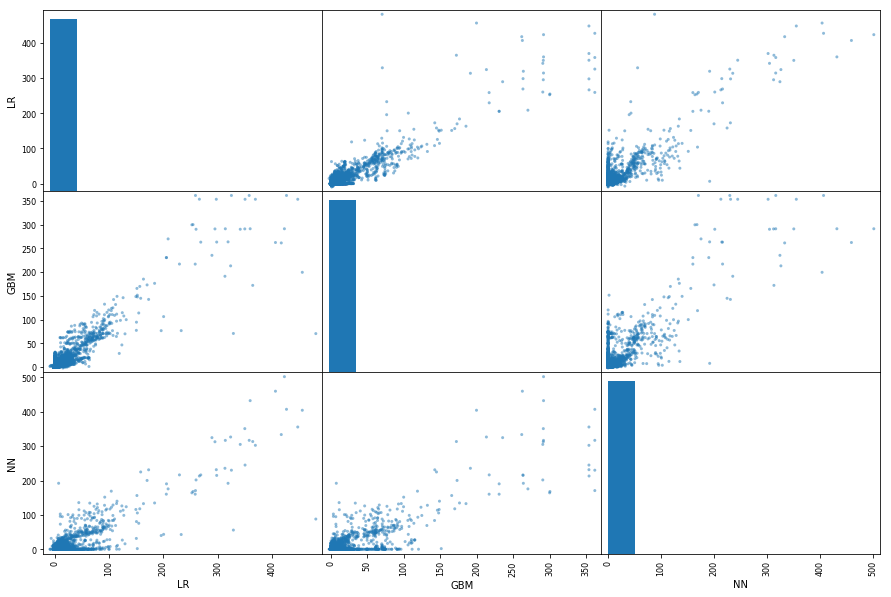

In [454]:
from pandas.plotting import scatter_matrix
scatter_matrix(pd.DataFrame(X_train_val_level2, columns=['LR', 'GBM', 'NN']), figsize=(15,10))

In [531]:
#
# build test meta features
#

X_test_level2 = np.zeros([X_test.shape[0], 3])
    
# LR
print('Processing LR')
lr_m = LinearRegression()
lr_m.fit(X_train_val.values, y_train_val)
X_test_level2[:, 0] = lr_m.predict(X_test.values)
    
# GBM
print('Processing GBM')
lgb_m = lgb.train(lgb_params, lgb.Dataset(X_train_val, label=y_train_val), 100)
X_test_level2[:, 1] = lgb_1st.predict(X_test)
    
# NN
print('Processing NN')
nn_m = baseline_nn_model()
nn_m.fit(X_train_val.values, y_train_val, epochs=10, batch_size=256, verbose=True, shuffle=False)
X_test_level2[:, 2] = nn_1st.predict(X_test.values).squeeze()

Processing LR
Processing GBM
Processing NN
Epoch 1/10
6425094/6425094 [==============================] - 46s 7us/step - loss: 9.2467
Epoch 2/10
6425094/6425094 [==============================] - 45s 7us/step - loss: 8.1406
Epoch 3/10
6425094/6425094 [==============================] - 45s 7us/step - loss: 8.2328
Epoch 4/10
6425094/6425094 [==============================] - 45s 7us/step - loss: 8.3522
Epoch 5/10
6425094/6425094 [==============================] - 46s 7us/step - loss: 8.0119
Epoch 6/10
6425094/6425094 [==============================] - 45s 7us/step - loss: 8.1021
Epoch 7/10
6425094/6425094 [==============================] - 45s 7us/step - loss: 8.2767
Epoch 8/10
6425094/6425094 [==============================] - 44s 7us/step - loss: 7.9850
Epoch 9/10
6425094/6425094 [==============================] - 44s 7us/step - loss: 7.7840
Epoch 10/10
6425094/6425094 [==============================] - 45s 7us/step - loss: 7.8699


## Stacking
### Simple LR for meta model

In [532]:
X_train_level2 = X_train_val_level2[dates_train_val_level2 < 33, :]
y_train_level2 = y_train_val_level2[dates_train_val_level2 < 33]

X_val_level2 = X_train_val_level2[dates_train_val_level2 == 33, :]
y_val_level2 = y_val

In [533]:
lr_meta = LinearRegression()
lr_meta.fit(X_train_level2, y_train_level2)

train_meta_preds = lr_meta.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_meta_preds)

val_meta_preds = lr_meta.predict(X_val_level2)
r2_val_stacking = r2_score(y_val, val_meta_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Val R-squared for stacking is %f' % r2_val_stacking)

Train R-squared for stacking is 0.307768
Val R-squared for stacking is 0.281456


### Ridge for meta model

min train_cost : 0.30776758884730493, min val_cost : 0.28145571137809533
optimal train alpha : 0.1, optimal val alpha : 0.1
Train R-squared for stacking is 0.307768
Val R-squared for stacking is 0.281456


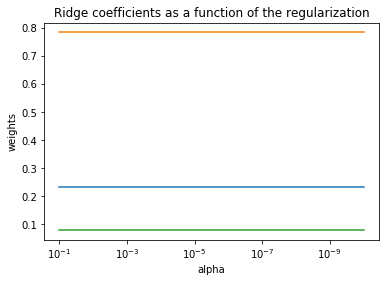

In [534]:
# hyper-param tunning
grid_alphas = np.logspace(-10, -1, 101)

train_cost = []
val_cost = []
coefs = []
for alp in grid_alphas:
    lr_meta = Ridge(alpha = alp)
    lr_meta.fit(X_train_level2, y_train_level2)
    coefs.append(lr_meta.coef_)
    
    train_meta_preds = lr_meta.predict(X_train_level2)
    train_cost.append(r2_score(y_train_level2, train_meta_preds))

    val_meta_preds = lr_meta.predict(X_val_level2)
    val_cost.append(r2_score(y_val, val_meta_preds))

optimal_alpha = grid_alphas[np.argmin(np.array(val_cost))]
print('min train_cost : {}, min val_cost : {}'.format(np.min(np.array(train_cost)), np.min(np.array(val_cost))))
print('optimal train alpha : {}, optimal val alpha : {}'.format(grid_alphas[np.argmin(np.array(train_cost))],
                                                                grid_alphas[np.argmin(np.array(val_cost))]))

lr_meta_final = Ridge(alpha = optimal_alpha)
lr_meta_final.fit(X_train_level2, y_train_level2)
train_meta_preds = lr_meta_final.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_meta_preds)

val_meta_preds = lr_meta_final.predict(X_val_level2)
r2_val_stacking = r2_score(y_val, val_meta_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Val R-squared for stacking is %f' % r2_val_stacking)

# plot
ax = plt.gca()

ax.plot(grid_alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [535]:
#X_train_val_level2
#y_train_val_level2
lr_meta_final = Ridge(alpha = optimal_alpha)
lr_meta_final.fit(X_train_val_level2, y_train_val_level2)
train_meta_preds = lr_meta_final.predict(X_train_val_level2)
r2_train_stacking = r2_score(y_train_val_level2, train_meta_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)

Train R-squared for stacking is 0.301622


## Test

In [446]:
#X_test_level2 = np.zeros([X_test.shape[0], 3])

#X_test_level2[:, 0] = lr_1st.predict(X_test.values)
#X_test_level2[:, 1] = lgb_1st.predict(X_test)
#X_test_level2[:, 2] = nn_1st.predict(X_test.values).squeeze()

In [536]:
test_preds = lr_meta_final.predict(X_test_level2)
# Normalize prediction to [0-20]
test_preds = list(map(lambda x: min(10, max(x, 0)), list(test_preds)))
test_result = pd.DataFrame({'ID': test.ID, 'item_cnt_month': test_preds})
test_result.describe()

,ID,item_cnt_month
count,"214,200.00","214,200.00"
mean,"107,099.50",0.29
std,"61,834.36",0.70
min,0.00,0.00
25%,"53,549.75",0.05
50%,"107,099.50",0.12
75%,"160,649.25",0.27
max,"214,199.00",10.00


In [537]:
import datetime
test_result.to_csv('final_test_pred_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d')), index=False)

## Store models and dataset for replaying without retraining

In [538]:
#import pickle
from sklearn.externals import joblib

joblib.dump(lr_m, './lr_m.pkl')
joblib.dump(lgb_m, './lgb_m.pkl')
nn_m.save('./nn_m.h5')
joblib.dump(lr_meta_final, './lr_meta_final_m.pkl')

['./lr_meta_final_m.pkl']

In [541]:
print(np.mean(y_val))
print(np.mean(test_preds))

0.298339
0.2935488557681687


### Current rank is 174th